In [0]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec


In [3]:
from google.colab import files 

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving data_3000.zip to data_3000.zip
User uploaded file "data_3000.zip" with length 3309996 bytes


In [5]:
! mkdir data_3000
! unzip data_3000.zip -d ./data_3000

mkdir: cannot create directory ‘data_3000’: File exists
Archive:  data_3000.zip
replace ./data_3000/22.5651.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./data_3000/22.5651.jpg  
  inflating: ./data_3000/23.119.jpg  
  inflating: ./data_3000/23.149.jpg  
  inflating: ./data_3000/23.2255.jpg  
  inflating: ./data_3000/23.2919.jpg  
  inflating: ./data_3000/23.3077.jpg  
  inflating: ./data_3000/23.3701.jpg  
  inflating: ./data_3000/23.388.jpg  
  inflating: ./data_3000/23.4496.jpg  
  inflating: ./data_3000/23.4706.jpg  
  inflating: ./data_3000/23.4709.jpg  
  inflating: ./data_3000/23.4904.jpg  
  inflating: ./data_3000/23.5079.jpg  
  inflating: ./data_3000/23.5414.jpg  
  inflating: ./data_3000/23.5748.jpg  
  inflating: ./data_3000/23.5762.jpg  
  inflating: ./data_3000/23.587.jpg  
  inflating: ./data_3000/23.5886.jpg  
  inflating: ./data_3000/23.5889.jpg  
  inflating: ./data_3000/23.6748.jpg  
  inflating: ./data_3000/23.6771.jpg  
  inflating: ./data_3000/23.6777

In [6]:
%tensorflow_version 2.x
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split



TensorFlow 2.x selected.


Using TensorFlow backend.


0


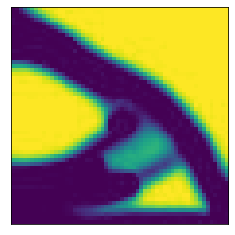

1


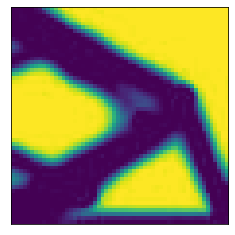

2


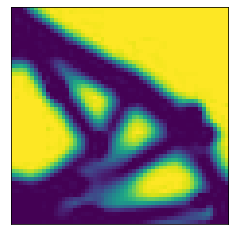

X_shape: (56, 56) Y_shape: ()
X_list shape: (3000, 56, 56) Y_list shape: (3000,)


In [14]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os 

src = './data_3000/'

def img_read_plot(src,file):
    img = cv.imread(src + file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()
    return img

def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

files = os.listdir(src)

X,Y = [],[]
count = 0

for file in files: 
  # Visualized 3 sample images
  # Normalized the image pixel range to 0~1
  if count < 3 :  
    print(count)
    X.append(img_read_plot(src,file)/255.)
    Y.append(float(file[:-4]))
    count+=1
  else : 
    X.append(img_read(src,file)/255.)
    Y.append(float(file[:-4]))

X = np.array(X)
Y = np.array(Y)

#Image size check
print('X_shape:',np.shape(X[0]),'Y_shape:',np.shape(Y[0]))
print('X_list shape:',np.shape(X),'Y_list shape:',np.shape(Y))

In [0]:
# Hyperparamenters
learning_rate = 0.001
training_epochs = 1000
batch_size = 32 
Buffer_size = 100

In [16]:
#Images are splitted to 80:20 ratio
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

print(np.shape(train_images))
print(np.shape(test_images))
print(np.shape(train_labels))
print(np.shape(test_labels))

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(Buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)



(2400, 56, 56, 1)
(600, 56, 56, 1)
(2400,)
(600,)


In [0]:
#Convolutional Net
class ConvBNRelu(tf.keras.Model):
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME'):
        super(ConvBNRelu, self).__init__()
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, kernel_regularizer=tf.keras.regularizers.l2(1e-5), strides=strides, 
                                        padding=padding, kernel_initializer='glorot_normal')
        self.batchnorm = tf.keras.layers.BatchNormalization()
    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer

In [0]:
#Fully Connected net 
class DenseBNRelu(tf.keras.Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = keras.layers.Dense(units=units, kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.batchnorm = tf.keras.layers.BatchNormalization()
    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer

In [0]:
#Final Model 
class AllModels(tf.keras.Model):
    def __init__(self):
        super(AllModels, self).__init__()
        self.conv1 = ConvBNRelu(filters=32)        
        self.pool1 = keras.layers.MaxPool2D()
        self.conv2 = ConvBNRelu(filters=64)
        self.pool2 = keras.layers.MaxPool2D()
        self.conv3 = ConvBNRelu(filters=128)
        self.pool3 = keras.layers.MaxPool2D()
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = DenseBNRelu(units=256)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=1)
    def call(self, inputs, training=False):
        net = self.conv1(inputs)        
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [24]:
#Summary of the model
model=AllModels()

temp_inputs = keras.Input(shape=(56, 56, 1))
model(temp_inputs)
model.summary()

Model: "all_models_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu_2 (ConvBNRelu)  (None, 56, 56, 32)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv_bn_relu_3 (ConvBNRelu)  (None, 28, 28, 64)        18752     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv_bn_relu_4 (ConvBNRelu)  (None, 14, 14, 128)       74368     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [25]:
#To calculate the validation accuracy using Root Mean Square Error(RMSE) & Mean Absolute Percentage Error(MAPE)
import keras.backend as K

def rmse (y_true, y_pred):  
  return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

model.compile(loss='MSE', optimizer='adam', metrics=[ rmse, 'mape' ]) 

history = model.fit(train_images, train_labels,      
          batch_size=batch_size,                      
          epochs=training_epochs,                    
          verbose=1,                                 
          validation_data=(test_images, test_labels)) 

score = model.evaluate(test_images, test_labels, verbose=0) 

print('Test loss(mse) :', score[0])
print('Test RMSE :', score[1])
print('Test MAPE :', score[2])

Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 22s 9ms/sample - loss: 525.0920 - rmse: 22.6984 - mape: 83.4614 - val_loss: 491.1826 - val_rmse: 22.1130 - val_mape: 81.4343
Epoch 2/1000
2400/2400 [==============================] - 21s 9ms/sample - loss: 200.6251 - rmse: 13.7481 - mape: 50.5435 - val_loss: 177.8344 - val_rmse: 13.2633 - val_mape: 48.7496
Epoch 3/1000
2400/2400 [==============================] - 21s 9ms/sample - loss: 48.0491 - rmse: 6.1498 - mape: 22.5882 - val_loss: 22.2318 - val_rmse: 4.5288 - val_mape: 16.5163
Epoch 4/1000
2400/2400 [==============================] - 21s 9ms/sample - loss: 14.0703 - rmse: 3.0381 - mape: 11.1560 - val_loss: 3.6178 - val_rmse: 1.5228 - val_mape: 5.5010
Epoch 5/1000
2400/2400 [==============================] - 21s 9ms/sample - loss: 12.3654 - rmse: 2.7936 - mape: 10.2655 - val_loss: 2.5573 - val_rmse: 1.2603 - val_mape: 4.6381
Epoch 6/1000
2400/2400 [==============================

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 모델 학습 후 정보가 담긴 history 내용을 토대로 선 그래프를 그리는 함수 설정

def plot_rmse(history, title=None):        
    # summarize history for RMSE
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['rmse'])        
    plt.plot(history['val_rmse'])    
    if title is not None:
        plt.title(title)
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

def plot_mape(history, title=None):        
    # summarize history for MAPE
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['mape'])        
    plt.plot(history['val_mape'])    
    if title is not None:
        plt.title(title)
    plt.ylabel('MAPE')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

def plot_loss(history, title=None):     # Loss Visualization
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])           # loss
    plt.plot(history['val_loss'])       # validation
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

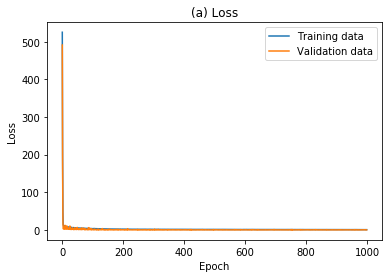

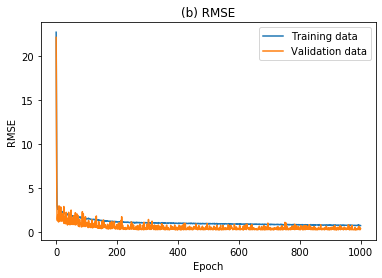

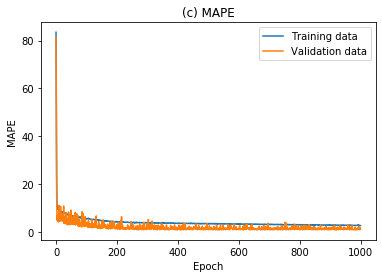

In [27]:
# Visualization
plot_loss(history, '(a) Loss')  # 학습 경과에 따른 정확도 변화 추이
plt.show()
plot_rmse(history, '(b) RMSE')     # 학습 경과에 따른 손실값 변화 추이
plt.show()
plot_mape(history, '(c) MAPE')     # 학습 경과에 따른 손실값 변화 추이
plt.show()
